In [1]:
import matplotlib as mpl
mpl.use('Agg')
from LiteNet import *
from Datasets import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm, trange
from scipy.stats import norm
from nystrom_kexpfam.estimators.KMCLite import KMCLite
from nystrom_kexpfam.data_generators.Ring import Ring
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

KERNEL_EXP_FAMILY: INFO: 2018-05-13 01:59:50,367: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handle = dnn._make_handle(context)
  File "/nfs/nhome/live/kevinli/anaconda/

In [2]:
D = 2
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)
p = Spiral(D=D, r_scale=1.5, sigma=0.1, starts=[0.1,0.5,1.5,4], length=np.pi)
p = Funnel(sigma=2, D=D, lim=10)


plot_size=12
ngrid = 100

eval_grid = np.linspace(-plot_size/2,plot_size/2,ngrid) 

if D == 2:
    eval_points = np.array([[xv,yv] 
        for xv in eval_grid
                for yv in eval_grid])


def gen_data(n):
        
    d = p.sample(n)
    
    return d

def visualize_kernel(kn, grid_one, N, points = np.array([[0,0.0]]),**kwargs):
    
    '''
    Plot effective kernels 
    '''
    ngrid = len(grid_one)
    npoint = points.shape[0]
    grid_one = grid_one.astype(FDTYPE)
    
    points = tf.constant(points, dtype=FDTYPE)
    
    grid = np.meshgrid(grid_one,grid_one)
    grid = np.stack(grid, 2).reshape(-1,2)

    grid = tf.constant(grid)

    K = kn.evaluate_gram(points, grid)
    K_eval = sess.run(K).reshape(npoint, ngrid,ngrid)
    
    for i in range(npoint):
        
        plt.contour(grid_one, grid_one, K_eval[i], N, 
                    vmin=K_eval[:-1,:-1].min(), vmax=K_eval[:-1,:-1].max(), **kwargs)
            
    plt.gca().set_aspect("equal")
    return K_eval

def true_score(gt, ge):
    return 0.5*np.mean(np.sum((gt - ge)**2,1))

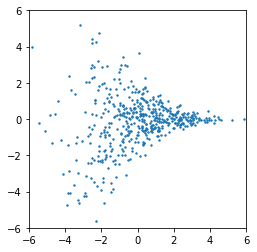

In [3]:
rand_train_data = gen_data(500)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1],2)
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.gca().set_aspect("equal")

### Training parameters
* `net_type`: `"d"` for deep kernel, need to specify `nlayer`
* `step_size`: step size for all algorithms
* `niter`: number of training iterations
* `ndim` : shape of input to the network as a tuple
* `npoint`: number of inducing points
* `ntrain:` number of training data
* `nvalid:`   number of validation data

### model parameters
* `init_std`: std for network weights
* `sigma`   : width of Gaussian kernel
* `tb_log_dir`: tensorboard log dir directory

In [4]:
np.random.seed(2)


net_type = "d" 
nlayer = 1
step_size = 1e-3
niter = 1000

ndim = (5,)
ntrain = 500
npoint = 100
nvalid = 500


init_std = 5e-1
init_sigma = 10**(-1)
init_log_lam = 0

tb_log_dir = "tb_logs/ds%s_nt%s_nl%d_ss%d_is%d" % (p.name, 
                                                   net_type, 
                                                   nlayer, 
                                                   np.log10(step_size), 
                                                   np.log(init_std))

In [5]:
train_data = tf.placeholder(FDTYPE, shape=(None, D), name="train_data")
val_data = tf.placeholder(FDTYPE, shape=(None, D), name="valid_data")
test_data = tf.placeholder(FDTYPE, shape=(None, D), name="test_data")
points  = tf.Variable(p.sample(npoint), dtype=FDTYPE, name="points")

rand_val_data = gen_data(nvalid)
rand_test_data = gen_data(nvalid)
rand_points = gen_data(npoint)

if hasattr(p, "grad_multiple"):
    test_grad_true = p.grad_multiple(rand_test_data)


print '=====building network'
if nlayer==0:
    kernel  = GaussianKernel(init_sigma)
    sigma = kernel.sigma
else:
    kernel  = GaussianKernel(init_sigma)
    layer_1 = LinearSoftNetwork((D,), ndim, init_std=init_std, scope="fc1")
    layers = [LinearSoftNetwork(ndim, ndim, init_std=init_std, scope="fc"+str(i+2)) for i in range(nlayer-1)]
    network = DeepNetwork([layer_1, ] + layers)
    kernel = CompositeKernel(kernel, network)
    #kernel = MixtureKernel([kernel, PolynomialKernel(2)], [1.0, -tf.constant(1e-2, dtype=FDTYPE)])
    #kernel = NetworkKernel(network)
    sigma = kernel.kernel.sigma

kn = LiteModel(kernel, points=points)

loss, score, train_data, val_data, r_norm, l_norm, curve, w_norm = \
    kn.val_score(train_data=train_data, val_data = val_data)

tf.summary.scalar("param_norm", w_norm)


hv, gv, fv = kn.evaluate_hess_grad_fun(test_data)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
#feed[points] = rand_points

tf.summary.scalar("score", score)
tf.summary.scalar("loss", loss)
tf.summary.scalar("lam_norm", kn.lam_norm)
tf.summary.scalar("lam_alpha", kn.lam_alpha)
tf.summary.scalar("lam_curve", kn.lam_curve)
tf.summary.scalar("rkhs_norm", r_norm)
tf.summary.scalar("l2_norm", l_norm)
tf.summary.scalar("curve", curve)

merged = tf.summary.merge_all()

=====building network


In [6]:
#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 10)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True




Visualise the kernel with random initialization

0.0707829


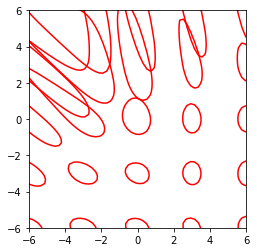

In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    if D == 2:
        points_grid = np.array([[i,j] for i in np.linspace(-6,6,5) for j in np.linspace(-6,6,5)])

        K_eval = visualize_kernel(kn, np.linspace(-10,10,100), [0.9], colors="red", points = points_grid);
        print K_eval.mean()

        plt.xlim(-plot_size/2,plot_size/2)
        plt.ylim(-plot_size/2,plot_size/2)

In [8]:
sess = tf.InteractiveSession(config=config)
#summary_writer = tf.summary.FileWriter(tb_log_dir, sess.graph)
sess.run(init)

In [14]:
niter = 2000

In [15]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lam_norms   = np.zeros(niter+1)
lam_alphas  = np.zeros(niter+1)
lam_curves  = np.zeros(niter+1)

fvs = []

t0 = time()

for i in range(niter+1):    

    feed[train_data] = gen_data(ntrain)
    feed[val_data] = gen_data(nvalid)
    #feed[points] = gen_data(npoint)



    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, w_norm_val, alpha_val = sess.run([score, r_norm, l_norm, 
                                                                        curve, w_norm, kn.alpha], 
        feed_dict=feed)

    #summary_writer.add_summary(summ, i)

    sigmas[i], lam_norms[i], lam_alphas[i] ,lam_curves[i]  = sess.run([sigma, kn.lam_norm, kn.lam_alpha, kn.lam_curve])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='

        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        if hasattr(p, "grad_multiple"):
            print 'true score', true_score(test_grad_true, gv_val)
        print 'sigma: %.5f' % sigma.eval()
        print 'lam_norm, lam_alpha, lam_curve, lam_weights, %.5g, %.5g, %.5g' % (
            lam_norms[i], lam_alphas[i], lam_curves[i])
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c, w = %.5g, %.5g, %.5g, %.5g' % (r_norm_val, l_norm_val, curve_val, w_norm_val)



Iteration     0, score -2.16 ( -0.5), time taken 0.05
true score 2.089890025
sigma: 0.20919
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0086427, 0.007607, 0.003951
alpha: 0.028993
rn, ln, c, w = 69.942, 42.649, 119.94, 9.1549
Iteration   100, score -4.21 ( -0.5), time taken 2.77
true score 2.04787585111
sigma: 0.20538
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0076044, 0.0067594, 0.0034845
alpha: 0.028306
rn, ln, c, w = 63.072, 34.179, 232.53, 9.2515
Iteration   200, score -2.77 ( -0.5), time taken 5.47
true score 2.11862153687
sigma: 0.21466
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0068568, 0.006258, 0.0031506
alpha: -0.011143
rn, ln, c, w = 82.913, 58.501, 184.77, 9.2797
Iteration   300, score -2.77 ( -0.5), time taken 8.14
true score 2.28182698182
sigma: 0.21680
lam_norm, lam_alpha, lam_curve, lam_weights, 0.0062683, 0.0058713, 0.002899
alpha: 0.026915
rn, ln, c, w = 74.364, 54.141, 137.6, 9.334
Iteration   400, score -3.32 ( -0.5), time taken 10.90
true score 1.9645923

In [23]:
#np.random.seed(3)
batch_size = 500
rand_train_data = gen_data(batch_size)
rand_test_data = gen_data(batch_size*10)

ge_kn = []
sc =    []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                              test_data: d, 
                                              val_data: d})
    ge_kn += [o1]
    sc    += [o2]

ge_kn = np.concatenate(ge_kn,0)
if hasattr(p, "grad_multiple"):
    gt = p.grad_multiple(rand_test_data)
print "cv model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "cv true score:  ", true_score(ge_kn, gt)

est = KMCLite(m = 500, sigma = np.exp(0.0024), lmbda = np.exp(-9.1224))

est.fit(rand_train_data)

ge = est.grad(rand_test_data)

sc = []
for i in range(rand_test_data.shape[0]/batch_size):
    d = rand_test_data[i*batch_size:(i+1)*batch_size]
    sc += [est.score(d)]
print "gs model score: ", np.mean(sc)
if hasattr(p, "grad_multiple"):
    print "gs true score:  ", true_score(ge, gt)


cv model score:  -3.06468
cv true score:   1.55233773794
gs model score:  777.157027867
gs true score:   782.035468532


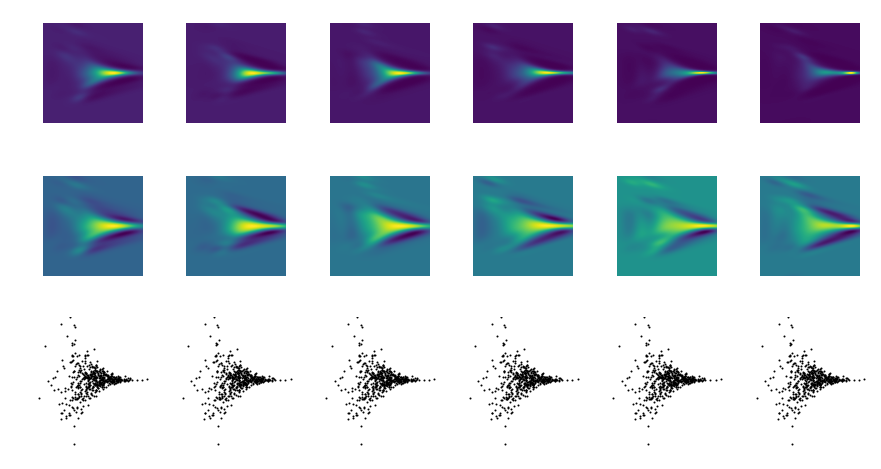

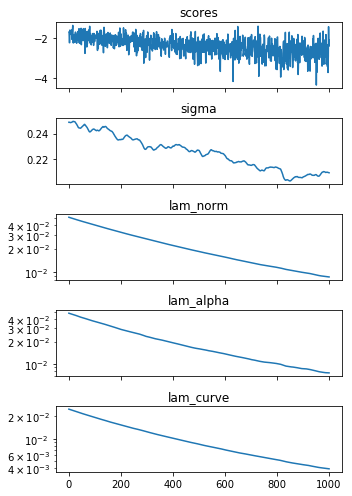

In [13]:
if D == 2:
    nfvs  = len(fvs)
    fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
    rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
    vmin = min(map(np.min, fvs))
    vmax = max(map(np.max, fvs))

    for i in range(len(fvs)):

        iter_number = niter/5*i
        ax = axes[0, i]

        hist = (fvs[i])

        ax.imshow( hist.reshape(ngrid, ngrid).T, origin="lower")
        #ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
        ax.set_axis_off()

        ax = axes[1, i]
        ax.imshow( np.log(hist).reshape(ngrid, ngrid).T, origin="lower")
        ax.set_axis_off()


        ax = axes[2, i]
        ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
        ax.set_axis_off()


    #plt.show()
    #fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
    #fig.savefig("figs/grid_dist/test.pdf") 

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lam_norms)
ax.set_title("lam_norm")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam_alphas)
ax.set_title("lam_alpha")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam_curves)
ax.set_title("lam_curve")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 

In [25]:
alpha_value = kn.alpha.eval(feed_dict=feed)
alpha = tf.Variable(alpha_value, dtype=FDTYPE, name="alpha")
init = tf.variables_initializer([alpha])
sess.run(init)

In [26]:
saver = tf.train.Saver()
save_path = saver.save(sess, "ckpts/funnel_D%d_l%d_nd%d_np%d.ckpt" % (D, nlayer, ndim[0], npoint))

In [27]:
fv_value, gv_value, hv_value = sess.run([fv, gv, hv], feed_dict={train_data:feed[train_data], 
                                 test_data:eval_points})
fv_value -= fv_val.mean()
fv_value = np.exp(fv_value)
fv_value /= np.sum(fv_value)
fv_value = fv_value.reshape(ngrid, ngrid)
gv_value = gv_value.reshape(ngrid,ngrid,2)

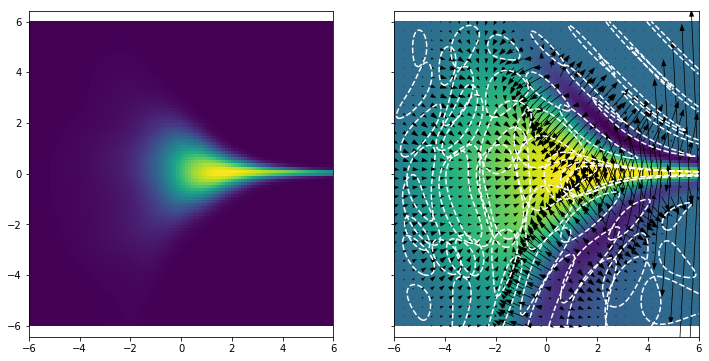

In [29]:
nkernel = 7
points_grid = np.array([[i,j] for i in np.linspace(-5,5,nkernel) for j in np.linspace(-5,5,nkernel)])
#points_grid = points.eval()
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True, sharey=True)

ax = axes[0]
ax.pcolor(eval_grid, eval_grid,
           ((fv_value.reshape(ngrid,ngrid))).T)

ax.set_aspect("equal")
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

ax = axes[1]

ax.pcolor(eval_grid, eval_grid,
           np.log((fv_value.reshape(ngrid,ngrid))).T)
g_int = 3
ax.quiver(eval_grid[::g_int], eval_grid[::g_int], gv_value[::g_int,::g_int,0].T, 
           gv_value[::g_int,::g_int,1].T, scale=50, headaxislength=10,headlength=10, headwidth=7)

ax.set_aspect("equal")

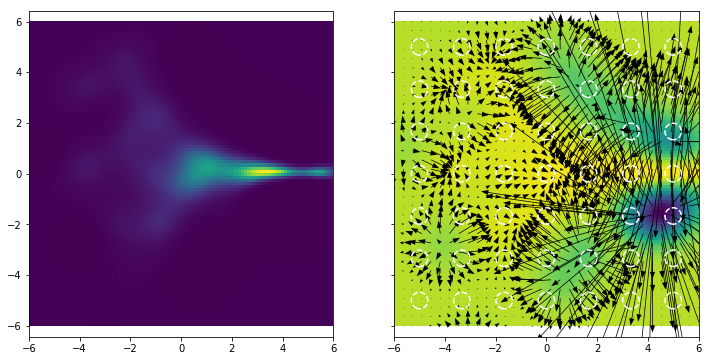

In [28]:
nkernel = 7
points_grid = np.array([[i,j] for i in np.linspace(-5,5,nkernel) for j in np.linspace(-5,5,nkernel)])
#points_grid = points.eval()
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True, sharey=True)

ax = axes[0]
ax.pcolor(eval_grid, eval_grid,
           ((fv_value.reshape(ngrid,ngrid))).T)

ax.set_aspect("equal")
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

ax = axes[1]

ax.pcolor(eval_grid, eval_grid,
           np.log((fv_value.reshape(ngrid,ngrid))).T)
g_int = 3
ax.quiver(eval_grid[::g_int], eval_grid[::g_int], gv_value[::g_int,::g_int,0].T, 
           gv_value[::g_int,::g_int,1].T, scale=50, headaxislength=10,headlength=10, headwidth=7)

ax.set_aspect("equal")

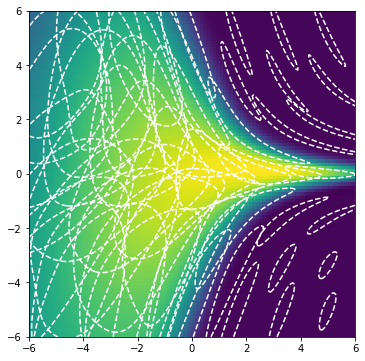

In [252]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,7) for j in np.linspace(-5,5,7)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

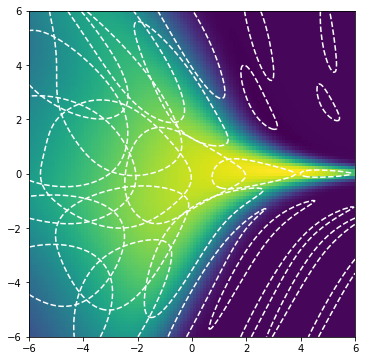

In [282]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

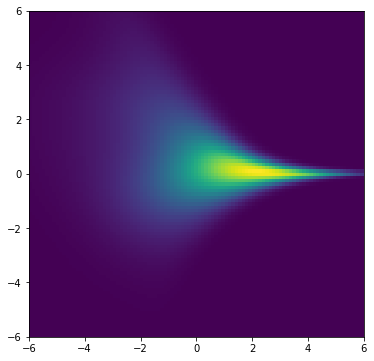

In [18]:
plt.figure(figsize=(6,6))
plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           ((hist.reshape(ngrid,ngrid))).T)

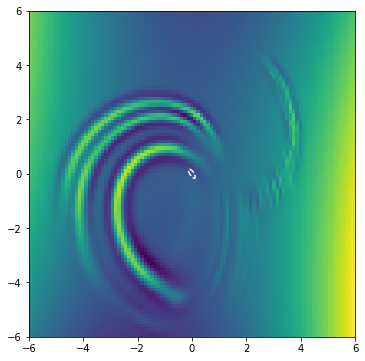

In [18]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,5) for j in np.linspace(-5,5,5)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

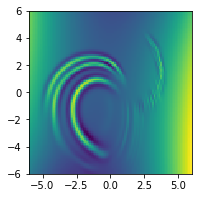

In [26]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(3,3))
#K = visualize_kernel(kn, np.linspace(-6,6,200), [0.1], points=points_grid, colors="white", linestyles="--")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")

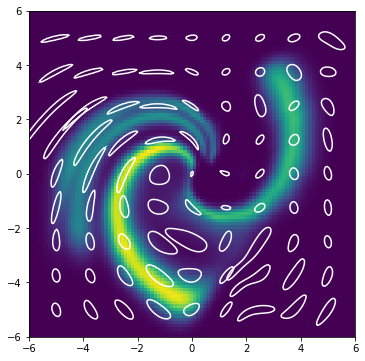

In [59]:
points_grid = np.array([[i,j] for i in np.linspace(-5,5,9) for j in np.linspace(-5,5,9)])

plt.figure(figsize=(6,6))
K = visualize_kernel(kn, np.linspace(-6,6,200), [0.9], points=points_grid, colors="white")

plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
           np.log((hist.reshape(ngrid,ngrid))).T)
plt.gca().set_aspect("equal")